# Supervised Image Classification

The framework allows to pre-train image models in supervised fashion using classification datasets.
For this example usage we will be using the [`BigEarthNet DataModule`](extra/bigearthnet.ipynb) inside a [`pytorch lightning`](https://pytorch-lightning.readthedocs.io/en/stable/) trainer. The network will be integrated into a [`LightningModule`](https://pytorch-lightning.readthedocs.io/en/stable/common/lightning_module.html).

First we start by importing the basics we need from `torch` and `pytorch_lightning` that are needed to set up the `LightningModule`.

In [1]:
# remove-output
# import packages
import pytorch_lightning as pl
import torch
import torch.nn.functional as F
from torch import optim

from configilm import ConfigILM

/home/lhackel/Documents/development/ConfigVLM/.venv/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Pytorch Lightning Module
The `Module` we use to encapsulate the model divides the usual loop into functions that are called internally by `pytorch_lightning`. The necessary functions are just `training_step` and `configure_optimizer`, but to have a fully functional script, we add the validation and test steps as well as evaluation of the validation and test results. All `*_step` functions are working on a single batch while `*_epoch_end` functions are called after all batches are used and are passed a list of all return values of their respective `*_step` functions.

In [49]:
class LitVisionEncoder(pl.LightningModule):
    """
    Wrapper around a pytorch module, allowing this module to be used in automatic
    training with pytorch lightning.
    Among other things, the wrapper allows us to do automatic training and removes the
    need to manage data on different devices (e.g. GPU and CPU).
    """
    def __init__(
        self,
        config: ConfigILM.ILMConfiguration,
        lr: float = 1e-3,
    ):
        super().__init__()
        self.lr = lr
        self.config = config
        self.model = ConfigILM.ConfigILM(config)

    def training_step(self, batch, batch_idx):
        x, y = batch
        x_hat = self.model(x)
        loss = F.binary_cross_entropy_with_logits(x_hat, y)
        self.log("train/loss", loss)
        return {"loss": loss}

    def configure_optimizers(self):
        optimizer = optim.AdamW(self.parameters(), lr=self.lr, weight_decay=0.01)
        return optimizer

    # ============== NON-MANDATORY-FUNCTION ===============

    def validation_step(self, batch, batch_idx):
        x, y = batch
        x_hat = self.model(x)
        loss = F.binary_cross_entropy_with_logits(x_hat, y)
        return {"loss": loss, "outputs": x_hat, "labels": y}

    def validation_epoch_end(self, outputs):
        avg_loss = torch.stack([x["loss"] for x in outputs]).mean()
        self.log("val/loss", avg_loss)

    def test_step(self, batch, batch_idx):
        x, y = batch
        x_hat = self.model(x)
        loss = F.binary_cross_entropy_with_logits(x_hat, y)
        return {"loss": loss, "outputs": x_hat, "labels": y}

    def test_epoch_end(self, outputs):
        avg_loss = torch.stack([x["loss"] for x in outputs]).mean()
        self.log("test/loss", avg_loss)

    def forward(self, batch):
        # because we are a wrapper, we call the inner function manually
        return self.model(batch)

## Configuring
Now that we have our model, we will use the `pytorch_lightning.Trainer` to run our loops. Results are logged to `tensorboard`.

We start by importing some callbacks used during training

In [3]:
from configilm.ConfigILM import ILMConfiguration, ILMType

as well as defining our hyperparameters.

In [4]:
model_name = "resnet18"
seed = 42
number_of_channels = 12
image_size = 120
epochs = 4
lr = 5e-4

Then we create the configuration for usage in model creation later.

In [5]:
# remove-output
# seed for pytorch, numpy, python.random, Dataloader workers, spawned subprocesses
pl.seed_everything(seed, workers=True)

model_config = ILMConfiguration(
    timm_model_name=model_name,
    hf_model_name=None,
    classes=19,
    image_size=image_size,
    channels=number_of_channels,
    network_type=ILMType.VISION_CLASSIFICATION
)

Global seed set to 42


We log the hyperparameters and create a [Trainer](https://pytorch-lightning.readthedocs.io/en/stable/common/trainer.html).

In [7]:
# remove-output
trainer = pl.Trainer(
    max_epochs=epochs,
    accelerator="auto",
    log_every_n_steps=1,
    logger=False,
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


## Creating Model + Dataset
Finally, we create the model defined above and our datamodule. We will be using a datamodule from this framework described in the Extra section.

In [8]:
# remove-input
# remove-output
import pathlib
my_data_path = str(pathlib.Path("").resolve().parent.joinpath("configilm").joinpath("extra").joinpath("mock_data").resolve(strict=True))
# set precision on Ampere cards to bfloat16
torch.set_float32_matmul_precision('medium')

In [50]:
# remove-output
from configilm.extra.BEN_DataModule_LMDB_Encoder import BENDataModule
model = LitVisionEncoder(config=model_config, lr=lr)
dm = BENDataModule(
    data_dir=my_data_path,  # path to dataset
    img_size=(number_of_channels, image_size, image_size),
    num_workers_dataloader=4,
)

Dataloader using 4 workers


/home/lhackel/Documents/development/ConfigVLM/configvlm/ConfigVLM.py:131: UserWarning: Keyword 'img_size' unknown. Trying to ignore and restart creation.
  warnings.warn(


## Running
Now we just have to call the `fit()` and optionally the `test()` functions.

:::{note}
These calls generate quite a bit of output depending on the number of batches and epochs. The output is removed for readability.
:::

In [51]:
# remove-output
trainer.fit(model, datamodule=dm)

/home/lhackel/Documents/development/ConfigVLM/.venv/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:613: UserWarning: Checkpoint directory /home/lhackel/Documents/development/ConfigVLM/docs/lightning_logs/version_0/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type      | Params
------------------------------------
0 | model | ConfigVLM | 11.2 M
------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.858    Total estimated model params size (MB)


(17:07:38) Datamodule setup called
Loading BEN data for train...
    25 patches indexed
    25 filtered patches indexed
Loading BEN data for val...
    25 patches indexed
    25 filtered patches indexed
setup took 0.00 seconds
  Total training samples:       25  Total validation samples:       25
                                                                            

`Trainer.fit` stopped: `max_epochs=4` reached.


In [11]:
# remove-output
trainer.test(model, datamodule=dm)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


(16:50:12) Datamodule setup called
Loading BEN data for test...
    25 patches indexed
    25 filtered patches indexed
setup took 0.00 seconds
  Total test samples:       25
Testing DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 106.40it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test/loss         │     0.612914502620697     │
└───────────────────────────┴───────────────────────────┘

[{'test/loss': 0.612914502620697}]

Here is an example forward call for the model. Since the input is normalized, the colors are slightly distorted. To display the image anyway, we select only the RGB channels and normalize this image to the range 0 to 1.

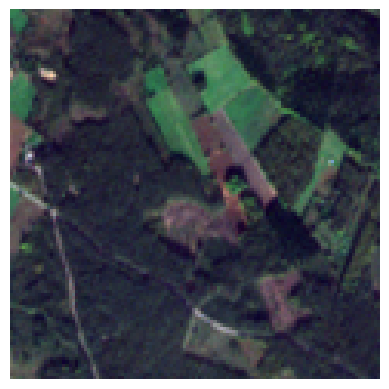

Expected: [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
    Real: [0.06139088422060013, -0.32617560029029846, 0.32982251048088074, -0.29078349471092224, -0.3959007263183594, -0.19642417132854462, 0.3104090094566345, 0.8245604038238525, 0.0148038100451231, -0.4634932279586792, -0.10085855424404144, -0.09883249551057816, 0.09365898370742798, -0.1684398651123047, 0.2485453188419342, 0.6295806765556335, -0.2910047471523285, -0.23813128471374512, -0.14067202806472778]


In [56]:
# remove-input
import matplotlib.pyplot as plt

img, lbl = dm.val_ds[9]
# only choose BGR axis for display and bring into RGB order
# only needed for displaying
img_display = torch.flip(img[:3], [0])
img_display -= torch.min(img_display)
img_display /= torch.max(img_display)

_ = plt.imshow(img_display.permute(1, 2, 0))
plt.axis('off')
plt.show()

# forward call, only use first result (batch size 1)
result = model(img.unsqueeze(0))[0]

print(f"Expected: {lbl.tolist()}")
print(f"    Real: {result.tolist()}")